<a href="https://colab.research.google.com/github/aetev/Learning-stuff-/blob/main/lern.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
!pip install pandas-ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
import numpy as np
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt

**Define functions**

In [36]:
def get_largest_value_array(Data, columns):
    # Subset the data frame to only include the specified columns
    sub_data = Data[columns]

    # Use the apply() function with the max() function to find the maximum value in each row of the subsetted data frame
    max_values = sub_data.apply(max, axis=1)

    # Create a new array that takes the maximum value from step 2 for each row of the original data frame
    max_array = np.array(max_values)
    
    return max_array
  
def get_smallest_value_array(Data, columns):
    # Subset the data frame to only include the specified columns
    sub_data = Data[columns]

    # Use the min() function to find the minimum value in each row of the subsetted data frame
    min_values = sub_data.min(axis=1)

    # Create a new array that takes the minimum value from step 2 for each row of the original data frame
    min_array = np.array(min_values)
    
    return min_array

def get_array_bo_greater_than_bc(Data):
    # Use np.where() to compare the "BO" and "BC" columns, return 1 if "BO" < "BC", and 0 otherwise
    result_array = np.where(Data["BO"] < Data["BC"], 1, 0)
    
    return result_array

def generate_dataframe(func, start, end, step, data):
    result_df = pd.DataFrame()

    for param in np.arange(start, end, step):
        result_array = func(param, data)
        temp_df = pd.DataFrame(result_array, columns=[f'param_{param}'])
        result_df = pd.concat([result_df, temp_df], axis=1)

    return result_df

**Load Data**

In [25]:
Data = pd.read_csv('/content/drive/MyDrive/eurusd_hour.csv')
Data['Date'] = pd.to_datetime(Data['Date'])
Data['Time'] = pd.to_datetime(Data['Time'])
print(Data)

            Date                Time       BO       BH       BL       BC  \
0     2005-05-02 2023-05-23 00:00:00  1.28520  1.28520  1.28400  1.28440   
1     2005-05-02 2023-05-23 01:00:00  1.28440  1.28480  1.28390  1.28420   
2     2005-05-02 2023-05-23 02:00:00  1.28430  1.28540  1.28410  1.28510   
3     2005-05-02 2023-05-23 03:00:00  1.28510  1.28590  1.28500  1.28510   
4     2005-05-02 2023-05-23 04:00:00  1.28520  1.28590  1.28490  1.28550   
...          ...                 ...      ...      ...      ...      ...   
93079 2020-04-29 2023-05-23 18:00:00  1.08620  1.08851  1.08611  1.08713   
93080 2020-04-29 2023-05-23 19:00:00  1.08711  1.08823  1.08659  1.08748   
93081 2020-04-29 2023-05-23 20:00:00  1.08747  1.08788  1.08691  1.08708   
93082 2020-04-29 2023-05-23 21:00:00  1.08708  1.08740  1.08699  1.08714   
93083 2020-04-29 2023-05-23 22:00:00  1.08728  1.08760  1.08727  1.08743   

           BCh       AO       AH       AL       AC      ACh  
0     -0.00080  1.28540  

**Extract time information**

In [26]:
Date = pd.DataFrame()

Date['day'] = Data['Date'].dt.day
Date['month'] = Data['Date'].dt.month
Date['weekday'] = Data['Date'].dt.weekday
Date['hour_of_day'] = Data['Time'].dt.hour

print(Date)

       day  month  weekday  hour_of_day
0        2      5        0            0
1        2      5        0            1
2        2      5        0            2
3        2      5        0            3
4        2      5        0            4
...    ...    ...      ...          ...
93079   29      4        2           18
93080   29      4        2           19
93081   29      4        2           20
93082   29      4        2           21
93083   29      4        2           22

[93084 rows x 4 columns]


**Candle stick and other chart info**

In [38]:
Shape = pd.DataFrame()

abs_diff_array = np.abs(Data['BH'] - Data['BL'])

updown_array = get_array_bo_greater_than_bc(Data)

max_array = get_largest_value_array(Data,["BC", "BO"])
min_array = get_smallest_value_array(Data,["BC", "BO"])

tp_array = (Data['BH']-min_array)/abs_diff_array
bp_array = (Data['BH']-max_array)/abs_diff_array

RelChange = Data['BC'] - Data['BO']

Shape["Direction"] = updown_array
Shape["Bottom_Point"] = bp_array
Shape["Top_Point"] = tp_array
Shape["Relative_Change"] = RelChange
Shape["Size"] = abs_diff_array




#print(Shape)
result = pd.concat([Date, Shape], axis=1)
print(new)

       param_10  param_15  param_20  param_25  param_30  param_35  param_40  \
0           NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1           NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2           NaN       NaN       NaN       NaN       NaN       NaN       NaN   
3           NaN       NaN       NaN       NaN       NaN       NaN       NaN   
4           NaN       NaN       NaN       NaN       NaN       NaN       NaN   
...         ...       ...       ...       ...       ...       ...       ...   
93079  1.085513  1.085607  1.085279  1.084741  1.084539  1.084924  1.084609   
93080  1.085709  1.085777  1.085494  1.084900  1.084645  1.084997  1.084736   
93081  1.085915  1.085884  1.085644  1.085055  1.084776  1.084984  1.084861   
93082  1.086211  1.086023  1.085773  1.085266  1.084895  1.084954  1.084978   
93083  1.086388  1.086055  1.085892  1.085488  1.085039  1.084922  1.085133   

       param_45  param_50  param_55  param_60  para

**Technical analysis**

(-0.05, 0.05)

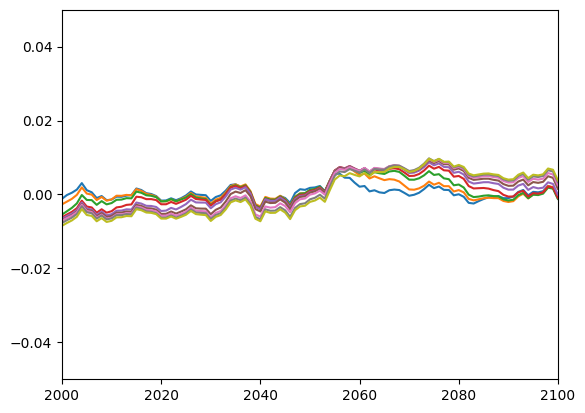

In [50]:
techana = pd.DataFrame()

close = Data["BC"]


def sma_func(hyperparameter, data):
    # Calculate the Simple Moving Average (SMA) using the ta.sma() function
    sma_result = ta.sma(data, length=hyperparameter)-data

    # Convert the resulting Series to a NumPy array
    result_array = sma_result.to_numpy()

    return result_array

sma1 = generate_dataframe(sma_func,10,100,10,close)


plt.plot(techana)

plt.xlim(2000,2100)
plt.ylim(-.05,.05)